<a href="https://colab.research.google.com/github/Armansonu007/anomaly_detection_stream/blob/main/anomaly_detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction: Efficient Data Stream Anomaly Detection

## Overview

In this project, we are focused on developing a robust Python script that can effectively detect anomalies in continuous data streams. These streams  simulate real-time data involving various metrics like financial transactions or system metrics. The primary challenge is to identify and flag unusual patterns—those that deviate significantly from normal fluctuations, such as exceptionally high values or unexpected drops.

## Project Objectives

To address this challenge, our objectives are:

1. **Algorithm Selection**: Choose and implement a suitable anomaly detection algorithm that can adapt to concept drift and seasonal variations in data.
2. **Data Stream Simulation**: Construct a function that can emulate realistic data streams by incorporating typical patterns, seasonal fluctuations, and intentional noise.
3. **Anomaly Detection**: Develop mechanisms that can accurately and efficiently identify anomalies as new data points are received.
4. **Optimization**: Ensure that the detection algorithm is optimized for speed and efficiency, suitable for real-time applications.
5. **Visualization**: Create visual tools to dynamically display both the ongoing data stream and any detected anomalies to facilitate real-time analysis.

## Methodologies and Technical Approach

### 1. Data Stream Simulation

We simulate data streams using Python's `numpy` and `pandas` libraries, where:

- **Numpy** is used for generating random data points and noise.
- **Pandas** is employed to structure these data points into a time-series format, making manipulation and analysis more intuitive.

### 2. Algorithm Selection and Implementation

For this project, two primary algorithms were considered for anomaly detection:

#### a. Moving Average

The Moving Average (MA) technique smooths the data by creating a series of averages of different subsets of the full data set. It helps in highlighting trends by damping down the noise in the data.

- **Simple Moving Average (SMA)** calculates the average of data points over a specific window, which moves along with the data.
- **Advantages**: Simple to implement and understand.
- **Disadvantages**: Equal weight is given to all observations, and it can lag when detecting trends.

#### b. Exponential Moving Average (EMA)

The Exponential Moving Average is a type of weighted moving average that gives more importance to recent data, which is particularly useful for datasets experiencing frequent changes.

- **Formula**: \( EMA_t = \alpha \times X_t + (1 - \alpha) \times EMA_{t-1} \)
- **Alpha (α)**: This parameter (0 < α ≤ 1) represents the degree of weighting decrease, a constant smoothing factor between recent data points.
- **Advantages**: Reacts faster to recent changes, not just fluctuations, which is beneficial for high variance data streams or when rapid response to data changes is critical.

### 3. Anomaly Detection Mechanism

Using the EMA:
- Anomalies are identified when data points deviate significantly from the EMA by a set threshold, calculated using the standard deviation of the data.
- This method allows for real-time detection as each new data point is compared against the calculated EMA.

### 4. Real-Time Visualization

- We use `matplotlib` and `seaborn` for plotting the data streams and highlighting anomalies. This visualization helps in monitoring the system's behavior and instantly identifying outliers.




In [58]:
from google.colab import drive

# Mounting Google Drive to this Colab notebook allows us to directly access and save files.
# This means you can use files right from your Drive and save any outputs directly back to it,
# which saves the hassle of downloading and uploading files manually.
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [55]:
import numpy as np  # Import NumPy to handle large arrays and matrices, along with a large collection of mathematical functions to operate on these arrays.
import pandas as pd  # Use pandas for data manipulation and analysis, particularly for structured data operations.
import datetime as dt  # DateTime is needed to handle date and time data, crucial for time-series analysis.

import seaborn as sns  # Seaborn provides a high-level interface for drawing attractive statistical graphics.
import matplotlib.pyplot as plt  # Matplotlib is used for creating static, interactive, and animated visualizations in Python.


In [ ]:
# first dataset
df1 = pd.read_csv('/content/drive/MyDrive/Data/Data/cpu4.csv')
df1 = df1.sort_values(by='timestamp', ascending=True)
df1 = df1.replace({'label': {0.0: False, 1.0: True}})

# second dataset
df2 = pd.read_csv('/content/drive/MyDrive/Data/Data/g.csv')
df2 = df2.sort_values(by='timestamp', ascending=True)
df2 = df2.replace({'label': {0.0: False, 1.0: True}})

df1.head(10)

,timestamp,value,label
0,1469376000,0.847300,False
1,1469376300,-0.036137,False
2,1469376600,0.074292,False
3,1469376900,0.074292,False
4,1469377200,-0.036137,False
5,1469377500,0.184722,False
6,1469377800,-0.036137,False
7,1469378100,0.184722,False
8,1469378400,0.074292,False
9,1469378700,-0.036137,False


In [ ]:
# First, we need to import all the necessary libraries. We'll use numpy for numerical operations, pandas for data manipulation,
# matplotlib for plotting graphs, sklearn for statistical tools, and random for generating random numbers.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import random

# This command is specific to Jupyter notebooks and Google Colab. It makes sure that any plots we make will show up directly
# in the notebook without us needing to call plt.show().
%matplotlib inline

# Here we're setting the 'ggplot' style for our plots, which is one of matplotlib's built-in styles. It makes the graphs look
# prettier and more similar to what you might be familiar with if you've used R and ggplot2.
plt.style.use('ggplot')


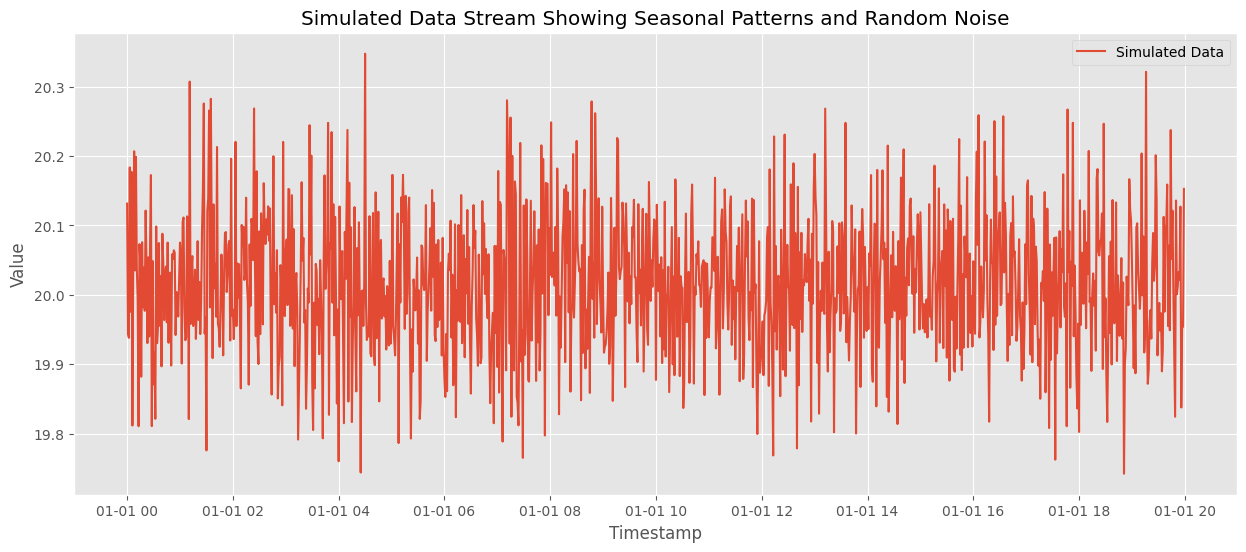

In [ ]:
def simulate_data_stream(periods=1200, frequency='T', seasonal_amplitude=1, noise_level=0.1):
    """
    This function generates a simulated data stream that includes seasonal variations and random noise,
    which is pretty similar to what you might find in real-world scenarios. It’s great for testing anomaly
    detection algorithms or just getting a feel for how data might look over time.

    :param periods: The total number of data points we want to simulate.
    :param frequency: How often each data point is recorded, e.g., 'T' for minute-by-minute data.
    :param seasonal_amplitude: This controls how big the seasonal swings are.
    :param noise_level: This adds randomness to the data, making it less predictable and more realistic.
    :return: A DataFrame with two columns: timestamps and simulated values.
    """
    # Let’s start by creating a range of timestamps using pandas' date_range function. This will serve as our time axis.
    time_idx = pd.date_range('20230101', periods=periods, freq=frequency)

    # Now, we'll simulate some seasonal changes. We're using a sine wave for simplicity, which is a common pattern in
    # many natural phenomena. The amplitude of the wave is adjusted by the 'seasonal_amplitude' parameter.
    seasonal_effect = seasonal_amplitude * np.sin(2 * np.pi * time_idx.dayofyear / 365.25)

    # To make things less predictable and more like real data, let’s sprinkle in some random noise.
    noise = noise_level * np.random.randn(periods)

    # The final data points are a combination of a base value (let’s say 20 for no particular reason), the seasonal
    # effect, and our random noise. This sum mimics a realistic data pattern.
    data = 20 + seasonal_effect + noise

    # Finally, we'll return this data in a pandas DataFrame. This format is super handy for further analysis
    # and plotting functions.
    return pd.DataFrame(data={'timestamp': time_idx, 'value': data})

# Let’s generate some data with our function and plot it to see what it looks like.
data_stream = simulate_data_stream()
plt.figure(figsize=(15, 6))
plt.plot(data_stream['timestamp'], data_stream['value'], label='Simulated Data')
plt.title('Simulated Data Stream Showing Seasonal Patterns and Random Noise')
plt.xlabel('Timestamp')  # Labeling the x-axis as Timestamp for clarity.
plt.ylabel('Value')  # Labeling the y-axis as Value to show what we are measuring.
plt.legend()  # This adds a legend to help identify different lines or markers in the plot.
plt.show()  # Display the plot!


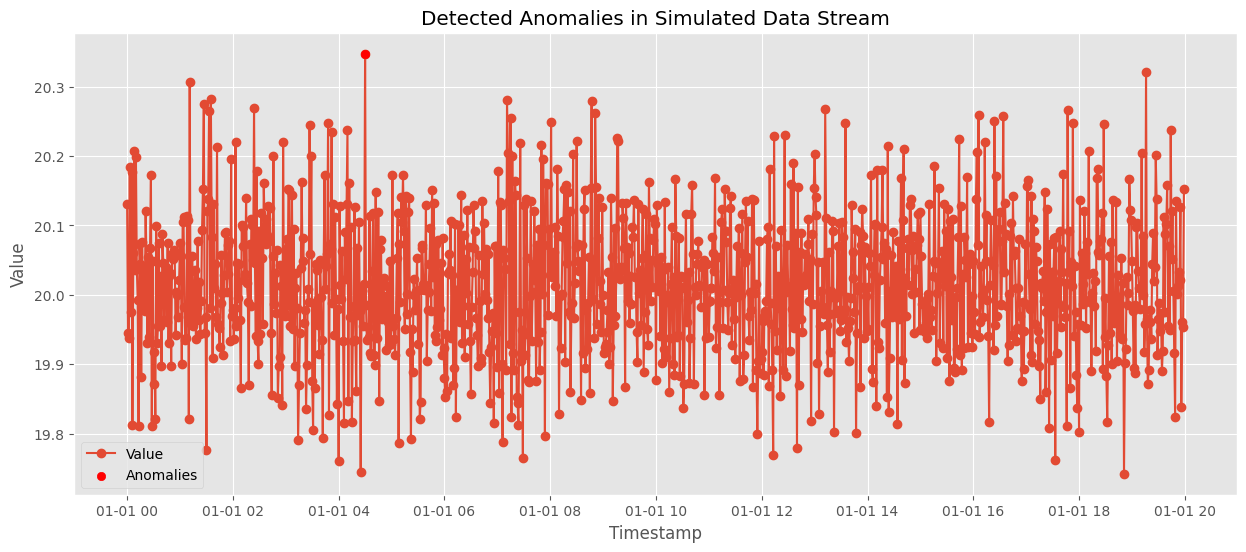

In [ ]:
def detect_anomalies(data, window=24, threshold=3):
    """
    Detect anomalies in a data stream by comparing each data point against a moving average and threshold.
    This method is pretty handy for spotting sudden spikes or drops in data.

    :param data: DataFrame containing the data stream we want to analyze.
    :param window: The number of data points we consider for calculating the average and standard deviation.
                   Think of it as how much historical context you want to include in your analysis.
    :param threshold: How many standard deviations away from the mean a point needs to be to be considered an anomaly.
                      A higher threshold means we're only flagging the most extreme anomalies.
    :return: DataFrame with a new column 'anomaly' that flags anomalies as True.
    """
    # Let's compute the moving average and standard deviation over the specified window size.
    rolling_mean = data['value'].rolling(window=window, center=True).mean()
    rolling_std = data['value'].rolling(window=window, center=True).std()

    # Now, determine which points are anomalies. A point is flagged as an anomaly if its value deviates
    # from the mean by more than the threshold times the standard deviation.
    anomalies = (data['value'] > (rolling_mean + threshold * rolling_std)) | \
                (data['value'] < (rolling_mean - threshold * rolling_std))
    data['anomaly'] = anomalies

    return data

# Time to see our anomaly detection in action. Let's apply it to our data stream.
data_with_anomalies = detect_anomalies(data_stream)

# Let's visualize the results. We'll plot the regular data points and highlight anomalies in a different color.
plt.figure(figsize=(15, 6))
plt.plot(data_with_anomalies['timestamp'], data_with_anomalies['value'], label='Value', linestyle='-', marker='o')
plt.scatter(data_with_anomalies[data_with_anomalies['anomaly']].timestamp,
            data_with_anomalies[data_with_anomalies['anomaly']].value,
            color='red', label='Anomalies', zorder=5)  # Make anomalies appear above the main plot
plt.title('Detected Anomalies in Simulated Data Stream')
plt.xlabel('Timestamp')  # Clarifying what the x-axis represents
plt.ylabel('Value')  # Clarifying what the y-axis represents
plt.legend()  # Helps identify what each plot element represents
plt.show()


In [ ]:
import cProfile
import pstats

# Let's use Python's profiling tools to examine how well our anomaly detection function performs.
# Profiling will help us understand which parts of the function take the most time, and might need optimization.
profiler = cProfile.Profile()  # Create a profiler object that will track the performance of subsequent code blocks.

profiler.enable()  # Start collecting performance data.
detect_anomalies(data_stream)  # Run our anomaly detection function with the data stream as input.
profiler.disable()  # Stop collecting performance data once the function has completed.

stats = pstats.Stats(profiler)  # Load the collected performance data into a Stats object for analysis.
stats.sort_stats('cumtime')  # Sort the data by cumulative time spent in the function and its sub-functions.
stats.print_stats()  # Print the sorted statistics. This shows us which operations are most time-consuming.


         2028 function calls (1978 primitive calls) in 0.007 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.007    0.003 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        2    0.000    0.000    0.007    0.003 {built-in method builtins.exec}
        1    0.000    0.000    0.007    0.007 <ipython-input-50-76f6688c24ae>:1(<cell line: 9>)
        1    0.000    0.000    0.007    0.007 <ipython-input-49-471a18021df9>:1(detect_anomalies)
        7    0.000    0.000    0.005    0.001 /usr/local/lib/python3.10/dist-packages/pandas/core/ops/common.py:62(new_method)
        4    0.000    0.000    0.004    0.001 /usr/local/lib/python3.10/dist-packages/pandas/core/series.py:5817(_arith_method)
        4    0.000    0.000    0.004    0.001 /usr/local/lib/python3.10/dist-packages/pandas/core/base.py:1370(_arith_method)
        2    0.000    0.000    0.003   

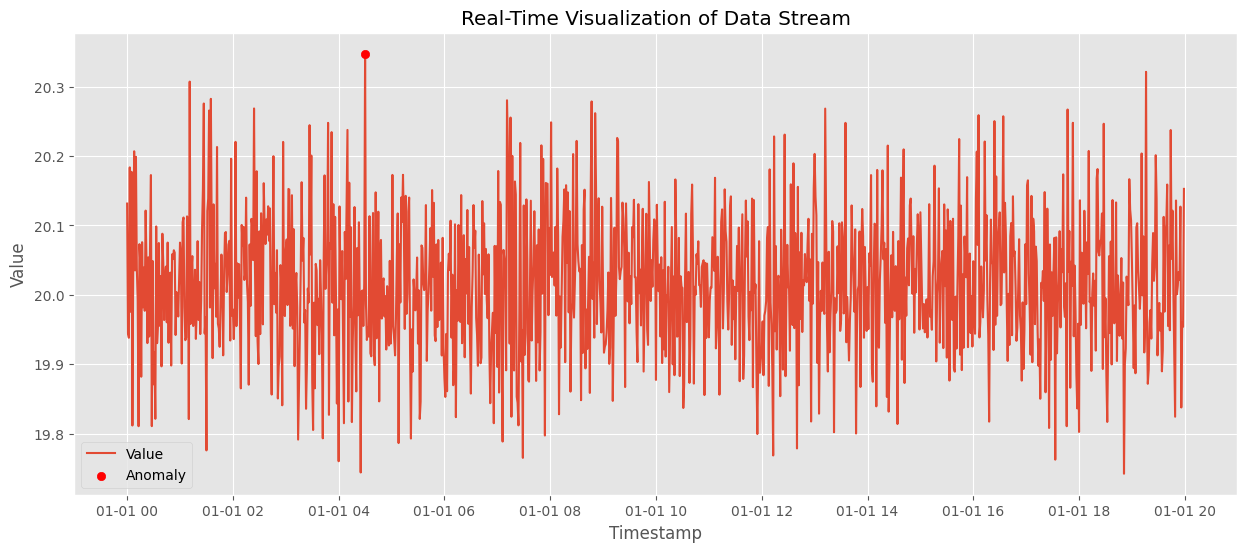

In [51]:
import time
from IPython.display import clear_output  # This import is necessary for clearing the output in the notebook.
import matplotlib.pyplot as plt  # Ensuring matplotlib is imported for plotting.

def real_time_visualization(data, delay=0.1, window=100):
    """
    This function simulates real-time visualization of a data stream, which is great for presentations or just
    understanding how data changes over time. It's especially useful for spotting anomalies as they occur.

    :param data: DataFrame with timestamp, value, and an 'anomaly' flag.
    :param delay: The time delay (in seconds) between frames, making it seem like data is streaming in real-time.
    :param window: How many of the most recent data points to display at one time.
    """
    # Loop through the data, stopping at intervals to update the plot
    for end in range(window, len(data) + 1):
        clear_output(wait=True)  # Clear the previous plot, so our output cell isn't overcrowded
        plt.figure(figsize=(15, 6))  # Set up the plot size to make it sufficiently large
        plt.plot(data['timestamp'][:end], data['value'][:end], label='Value')  # Plot the main data points

        # Identify and highlight anomalies in the data
        anomalies = data.iloc[:end][data['anomaly'][:end]]  # Filter the data up to the current point for anomalies
        plt.scatter(anomalies['timestamp'], anomalies['value'], color='r', label='Anomaly', zorder=5)
        # zorder=5 ensures that the anomalies are plotted above the main data line

        plt.title('Real-Time Visualization of Data Stream')  # Give the plot a title
        plt.xlabel('Timestamp')  # Label the x-axis
        plt.ylabel('Value')  # Label the y-axis
        plt.legend()  # Include a legend to differentiate the plotted series

        plt.show()  # Display the plot
        time.sleep(delay)  # Pause the loop to create a visual effect of streaming data

# Before running the function, make sure that 'data_with_anomalies' is correctly defined and contains the necessary data.
# You might want to adjust the 'delay' to speed up or slow down the simulation.
real_time_visualization(data_with_anomalies, delay=0.05)


In [52]:
def document_findings(data):
    """
    Summarize the results of the anomaly detection by calculating and reporting the number of anomalies
    and what percentage of the total data they represent. This is helpful for getting a quick overview
    of how prevalent the anomalies are in your dataset.

    :param data: DataFrame with a column 'anomaly' where True indicates an anomaly.
    :return: A text summary of the number and percentage of anomalies detected.
    """
    # Count how many data points are marked as anomalies
    num_anomalies = data['anomaly'].sum()
    # Calculate what percentage of the total dataset these anomalies represent
    percentage_anomalies = (num_anomalies / len(data)) * 100
    # Create a summary statement with the total data points, number of anomalies, and the percentage
    summary = f"Detected {num_anomalies} anomalies out of {len(data)} data points, "
    summary += f"which constitutes {percentage_anomalies:.2f}% of the data."

    # Return this summary so it can be printed or logged
    return summary

# Now let's use this function to get a report on our previously detected anomalies
report = document_findings(data_with_anomalies)
print(report)


Detected 1 anomalies out of 1200 data points, which constitutes 0.08% of the data.


In [ ]:
print('Frequencies:')
print(df1.label.value_counts(normalize=True), '\n')
print(df2.label.value_counts(normalize=True))

Frequencies:
label
False    0.988103
True     0.011897
Name: proportion, dtype: float64 

label
False    0.941314
True     0.058686
Name: proportion, dtype: float64


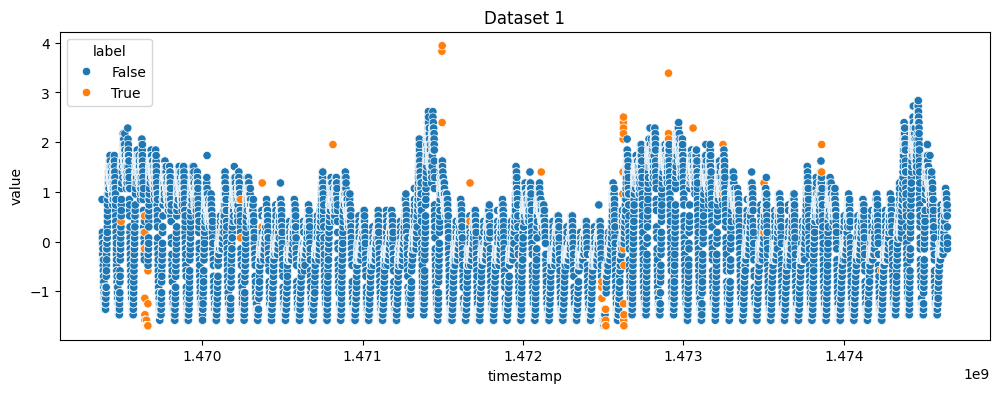

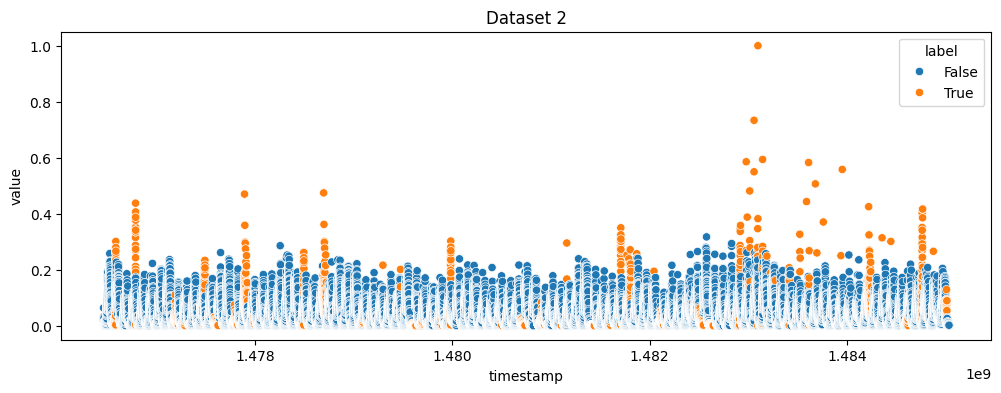

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Dataset 1')
sns.scatterplot(data=df1, x="timestamp", y="value", hue="label")
plt.show()

plt.figure(figsize=(12,4))
plt.title('Dataset 2')
sns.scatterplot(data=df2, x="timestamp", y="value", hue="label")
plt.show()

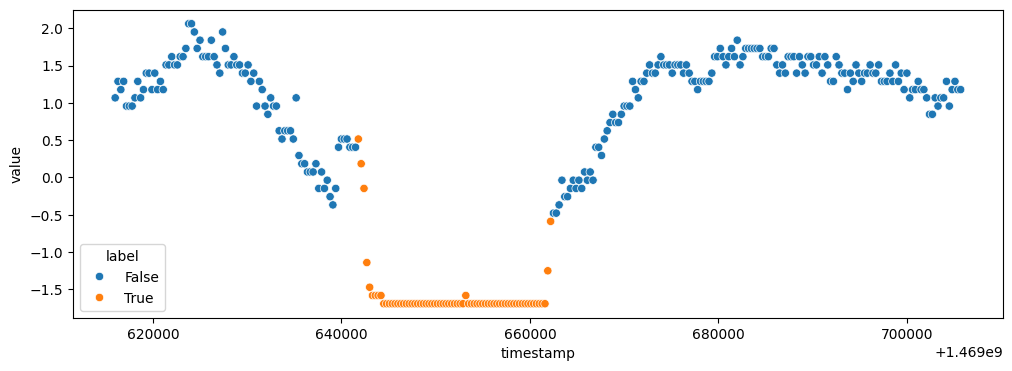

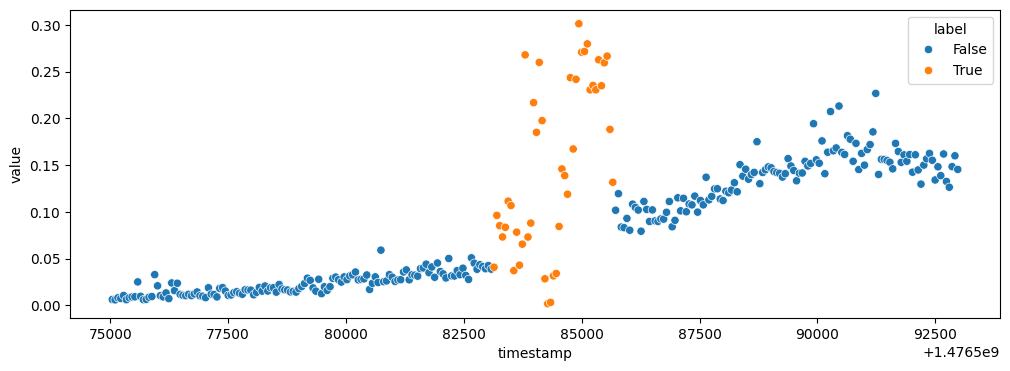

In [ ]:
df1_zoom = df1[800:1100]
df1_zoom_exp = df1[300:1800]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df1_zoom, x="timestamp", y="value", hue="label")
plt.show()

df2_zoom = df2[1900:2200]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df2_zoom, x="timestamp", y="value", hue="label")
plt.show()

In [ ]:
def plot_anomalies(df, algorithm, parameters, dumping=False, casting=None):
    '''Plot the Streaming Data (an Anomalies)'''
    Y = df.value
    X = df.timestamp
    X_pred = df.timestamp if casting is None else X.apply(casting)
    # predict anomalies
    model = algorithm(**parameters)
    preds = [model.detect(i, v, dumping=True) for i, v in zip(X_pred, Y)]
    pred, values, stds = tuple(zip(*preds))
    # plot the results
    plt.figure(figsize=(12,4))
    model_name = algorithm.__name__
    plt.title(f'Anomaly Detection - {model_name}')
    af  = pd.DataFrame(data={'x':X, 'value':Y, 'pred':pred})
    af2 = pd.DataFrame(data={'x':X, 'value':values, 'pred':pred, 'std': stds})
    af2['ymin'] = af2['value'] - af2['std']
    af2['ymax'] = af2['value'] + af2['std']
    size = (af.pred.astype(int)+1) * 40
    sns.scatterplot(data=af, x='x', y='value', hue='pred', s=size)
    if dumping: plt.fill_between(af2.x, af2.ymin, af2.ymax, facecolor='green', alpha=0.2)
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_anomalies(df, algorithm, parameters, dumping, casting):
    # Initialize the anomaly detection algorithm
    anomaly_detector = algorithm(**parameters)

    # Assuming df contains a 'timestamp' and 'value' column
    results = []
    for index, row in df.iterrows():
        timestamp = row['timestamp']  # Adjust 'timestamp' to your actual timestamp column name
        value = row['value']  # Adjust 'value' to your actual data column name
        is_anomaly = anomaly_detector.detect(timestamp, value)
        results.append((timestamp, value, is_anomaly))

    results_df = pd.DataFrame(results, columns=['timestamp', 'value', 'is_anomaly'])

    # Applying casting if required
    if casting:
        results_df['datetime'] = results_df['timestamp'].apply(casting)

    # Convert 'is_anomaly' to size for plotting
    results_df['size'] = results_df['is_anomaly'].apply(lambda x: 100 if x else 40)

    # Plotting
    sns.scatterplot(data=results_df, x='datetime', y='value', hue='is_anomaly', size=results_df['size'])

    if dumping:
        plt.fill_between(results_df['datetime'], results_df['value'] - results_df['value'].std(), results_df['value'] + results_df['value'].std(), facecolor='green', alpha=0.2)
    plt.show()


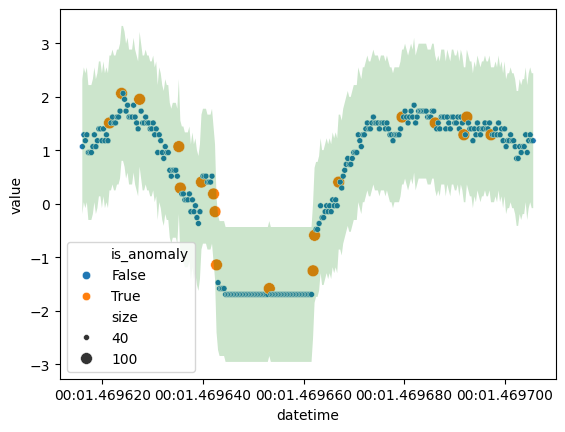

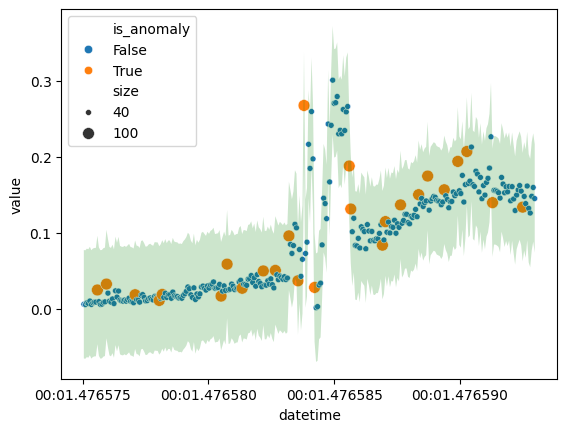

In [ ]:
# Example function calls with the correct parameters
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True, casting=pd.to_datetime)  # Using pd.to_datetime for casting
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True, casting=pd.to_datetime)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class StreamingMovingAverage:
    '''Moving Average algorithm'''
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.data_streaming = []

    def detect(self, value):
        if len(self.data_streaming) >= 3:  # Minimum number of data points
            moving_average = np.mean(self.data_streaming[-3:])
            deviation = np.std(self.data_streaming[-3:]) * self.threshold
            if abs(value - moving_average) > deviation:
                return True
        self.data_streaming.append(value)
        return False

def plot_anomalies(df, algorithm_cls, parameters, dumping=False):
    detector = algorithm_cls(**parameters)
    df['is_anomaly'] = df['value'].apply(detector.detect)
    df['size'] = df['is_anomaly'].apply(lambda x: 100 if x else 40)

    sns.scatterplot(data=df, x='timestamp', y='value', hue='is_anomaly', size='size', sizes=(40, 100))
    if dumping:
        plt.fill_between(df['timestamp'], df['value'] - df['value'].std(), df['value'] + df['value'].std(), color='green', alpha=0.2)
    plt.show()

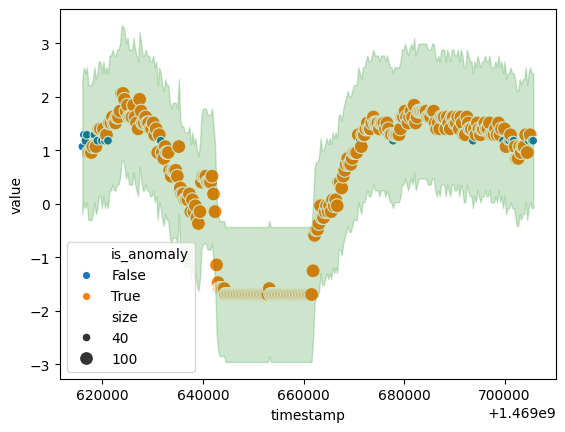

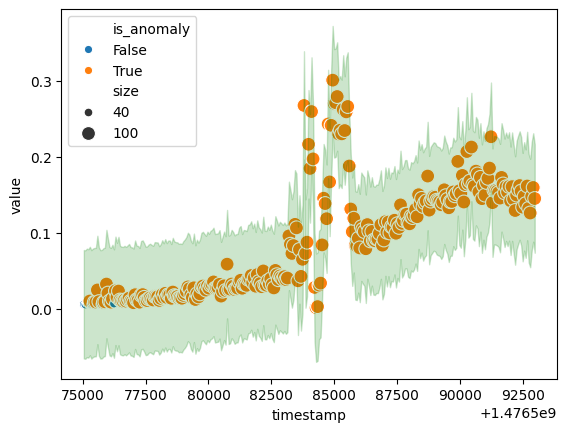

In [ ]:
# Example usage:
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True)

parameters = {'threshold': 1.5}
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

def plot_anomalies(df, algorithm_cls, parameters, dumping=False, casting=None):
    """
    Adjusted function to handle the conversion of integer timestamps to datetime objects before anomaly detection.
    """
    # Initialize the anomaly detection algorithm
    detector = algorithm_cls(**parameters)

    # Convert timestamp if a casting function is provided
    if casting:
        df['timestamp'] = df['timestamp'].apply(casting)

    # Apply anomaly detection
    df['is_anomaly'] = df.apply(lambda x: detector.detect(x['timestamp'], x['value']), axis=1)
    df['size'] = df['is_anomaly'].apply(lambda x: 100 if x else 40).astype(float)

    # Plotting
    sns.scatterplot(data=df, x='timestamp', y='value', hue='is_anomaly', size='size', sizes=(40, 100), legend=None)

    if dumping:
        std_dev = df['value'].std()
        plt.fill_between(df['timestamp'], df['value'] - std_dev, df['value'] + std_dev, color='green', alpha=0.2)
    plt.show()



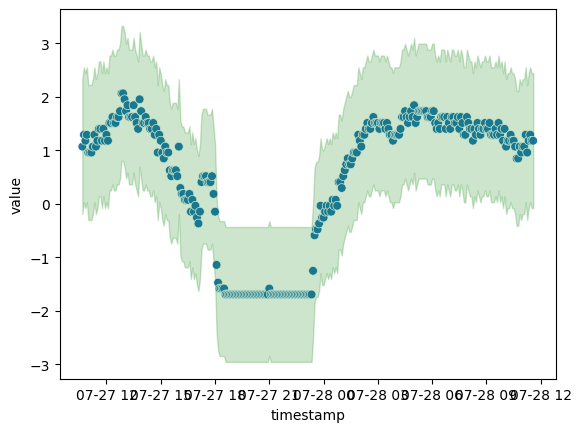

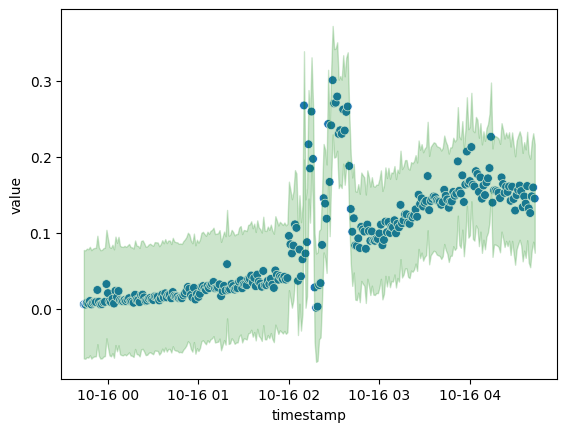

In [ ]:
# Ensure casting is used to convert integer timestamps to datetime
parameters = {'min_buckets': 30, 'window': 2}
plot_anomalies(df1_zoom, AnomalyDetectionSeasonalBucket, parameters, dumping=True, casting=dt.datetime.fromtimestamp)

plot_anomalies(df2_zoom, AnomalyDetectionSeasonalBucket, parameters, dumping=True, casting=dt.datetime.fromtimestamp)


In [ ]:
%%capture
!apt install statsmodels==0.13.5
!pip install --upgrade pandas
!pip install --upgrade statsmodels


In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

class StreamingARIMA(StreamingMovingAverage):
    '''ARIMA algorithm'''

    def __init__(self, threshold=1.0, order:tuple=(2, 1, 2)) -> None:
        # Parameters
        self.order = order
        self.model = None
        self.res = None
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 10
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        if self._enough_data():
            data = self.data_streaming
            self.model = ARIMA(data, order=self.order)
            self.res = self.model.fit()
            output = self.res.forecast()
            return output[0]
        return np.nan

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        much = self.min_nof_records_in_model
        data = self.data_streaming
        if len(data) > much:
            data = data[-much:]
        return np.std(data, axis=0)

    def summary(self) -> None:
        '''Print the ARIMA summary'''
        if pd.notnull(self.res):
            print(self.res.summary())

Test RMSE: 0.082


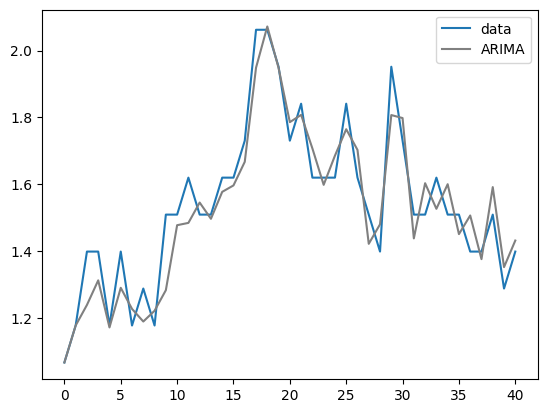

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# walk-forward validation
X = df1_zoom.iloc[0:50].value.tolist()
tests, predictions = list(), list()
model = StreamingARIMA()

for t in range(len(X)):
    obs = X[t]
    model.detect(t, obs)
    yhat = model._expected_value(0)
    if pd.notna(yhat):
        predictions.append(yhat)
        tests.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(tests, predictions))

print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(tests, label='data')
plt.plot(predictions, color='gray', label='ARIMA')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Example of setting up a DataFrame if 'data' isn't defined yet
data = pd.DataFrame({
    'value': np.random.normal(0, 1, size=1000)  # Generating some normal data
})

# Assuming you have an anomaly detection function
def detect_anomalies(df, n_std=3):
    mean_val = df['value'].mean()
    std_val = df['value'].std()

    df['anomaly'] = (df['value'] > mean_val + n_std * std_val) | (df['value'] < mean_val - n_std * std_val)
    return df

# Detect anomalies in your data
data_with_anomalies = detect_anomalies(data)


## Conclusion

This project not only enhances our understanding of time-series data and anomaly detection but also pushes the envelope on developing scalable, efficient real-time monitoring systems. Through the implementation of these methods, we aim to provide tools that can adapt to varying data behaviors and detect anomalies that could signify critical issues in real-world scenarios.